# Analyze landfast ice

Import modules

In [2]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
# %matplotlib notebook

Load data

In [3]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

# Read in data
nc = Dataset(path + region + '.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
juld = nc.variables['juld'][:]
land = nc.variables['land'][:][600:1450,1700:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]       

CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100

In [4]:
# Date time information
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months_unique = np.unique(months)
years_unique = np.unique(years)

In [5]:
years_unique

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

### Functions

In [6]:
# Function for setting up cartopy map

def plot_cartopy():
    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='black',
    facecolor=('silver'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='dimgrey')

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
    #     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
    # domain = [55, -61.30979545701268, 59, -61]

    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
    # Rotation for vertical coast
#     rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

#     # Plot results
#     transform = rot.transform_points(rot,lon,lat)
#     x_n = transform[...,0]
#     y_n = transform[...,1]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1, projection=rot)
    ax.add_feature(LAND_highres,zorder=2)
    ax.add_feature(OCEAN_highres,zorder=3)
    ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
    ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)

In [107]:
# Convert to distance from degree. 1 degree lat = 110km. 1 degree lon = 111.320*cos(latitude) km.
def deg2km(lat,lon):
    u_km = lon*111*np.cos(lat)
    v_km = lat*111
    return abs(u_km), abs(v_km)

### Get contour lines of sina

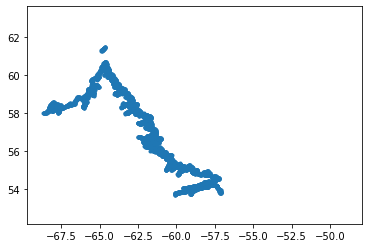

In [8]:
# Get land values
CS = plt.contour(lon, lat, land, levels=[0])
sina = CS.allsegs
sina = np.concatenate(np.concatenate(sina, axis=0))
landlon = sina[:,0]
landlat = sina[:,1]
plt.plot(landlon,landlat,'.')

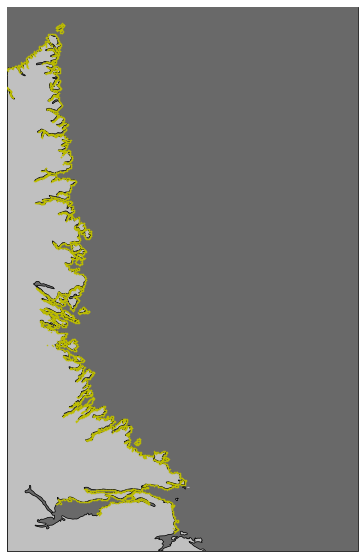

In [10]:
plot_cartopy()
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)
transform = rot.transform_points(rot,landlon,landlat)
x_n = transform[...,0]
y_n = transform[...,1]

plt.plot(x_n,y_n,'y.',markersize=1,transform=ccrs.PlateCarree(),zorder=4)

Issues: land contour is not uniform. Plus there are islands. Difficult to find distance between land and sina. Maybe try plotting distance between sina of a relative year and all other years?

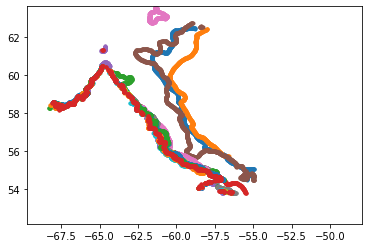

In [96]:
cnt=0

# x and y store the contour lines for each year (24 years)

x=[]
y=[]
for yr in years_unique:
    # March of every year
    which = (years == yr) * (np.array(months) == 4)

    if np.sum(which) >= 1:
        tt = np.where(which)[0][0]
#         plt.contour(x_n, y_n, CT[tt,:,:], levels=[99.9])
        CS = plt.contour(lon, lat, CT[tt,:,:], levels=[99.9])
        # allsegs gets the values of the contour line
        sina = CS.allsegs
        sina = np.concatenate(np.concatenate(sina, axis=0))
        xarr = sina[:,0]
        yarr = sina[:,1]
        plt.plot(xarr,yarr,'.')

        transform = rot.transform_points(rot,xarr,yarr)
        x.append(transform[...,0])
        y.append(transform[...,1])
    cnt += 1

In [97]:
# Filter out weird contours

X=[]
Y=[]
years_sina=[]
for i in range(len(x)):
    if np.nanmean(x[i]) < -60.5: # if the sina is the true sina (average lat is not greater than 60.5)
        X.append(x[i])
        Y.append(y[i])
        # Store years not filtered out
        years_sina.append(years_unique[i])
        

indices 4, 7, 9 of X and Y are weird

Try: Define new coastline (take most Eastward lat point on Mainland) for each defined section of the current coastline, create new latitudinal grid. Then, interpolate landfast ice edge coordinates on new latitude grid.

In [98]:
coastlon=[]
coastlat=[]
n = 20 # group size

for i in range(0, len(landlon), n):
    # find more eastward point of the coastline within the group 
    most_east_idx = np.where(landlon == np.nanmax(landlon[i:i + n]))
    coastlon.append(landlon[most_east_idx[0][0]])
    coastlat.append(landlat[most_east_idx[0][0]])

coastlon = np.array(coastlon)
coastlat = np.array(coastlat)

# Remove points in HB
coastlat = coastlat[coastlon>-64]
coastlon = coastlon[coastlon>-64]

# Sort by decreasing latitude
coastlat,coastlon = (np.array(t) for t in zip(*sorted(zip(coastlat,coastlon))))



# filter out weird points
# coastlon = np.concatenate((coastlon[12:20],coastlon[22:-1]))
# coastlat = np.concatenate((coastlat[12:20],coastlat[22:-1]))


In [100]:
# Reduce domain

sinalon_red=[]
sinalat_red=[]
for i in range(len(Y)):
    inds = (np.where( (Y[i] > np.min(coastlat)) & (Y[i] < np.max(coastlat)) & (X[i] > -64)))
    if len(inds[0]) > 0:
        sinalat_red.append(Y[i][inds])
        sinalon_red.append(X[i][inds])

In [102]:
# interpolating on coastline

d_km = []
for i in range(len(sinalon_red)):
    f = interp1d(sinalat_red[i],sinalon_red[i],kind='nearest',fill_value="extrapolate")
    
    u_km, v_km = deg2km(coastlat, f(coastlat) - coastlon)
    d_km.append(u_km)

# plt.scatter(f(coastlat_red[i]), coastlat_red[i],c=d_km[i]) 

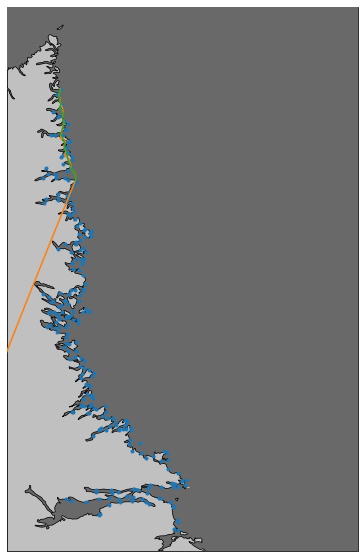

In [103]:
plot_cartopy()

# Plot coastline
# for i in range(2):
#     f = interp1d(sinalat_red[i],sinalon_red[i],kind='nearest',fill_value="extrapolate")
#     im = plt.plot(f(coastlat),coastlat,'.',transform=ccrs.PlateCarree(),zorder=4)

i = 4
plt.plot(coastlon, coastlat,'.', transform=ccrs.PlateCarree(),zorder=4)
f = interp1d(sinalat_red[i],sinalon_red[i],kind='nearest',fill_value="extrapolate")
plt.plot(f(coastlat),coastlat,transform=ccrs.PlateCarree(),zorder=4)
plt.plot(sinalon_red[i],sinalat_red[i],transform=ccrs.PlateCarree(),zorder=4)
              

In [106]:
len(years_sina)

18

ValueError: The number of FixedLocator locations (17), usually from a call to set_ticks, does not match the number of ticklabels (18).

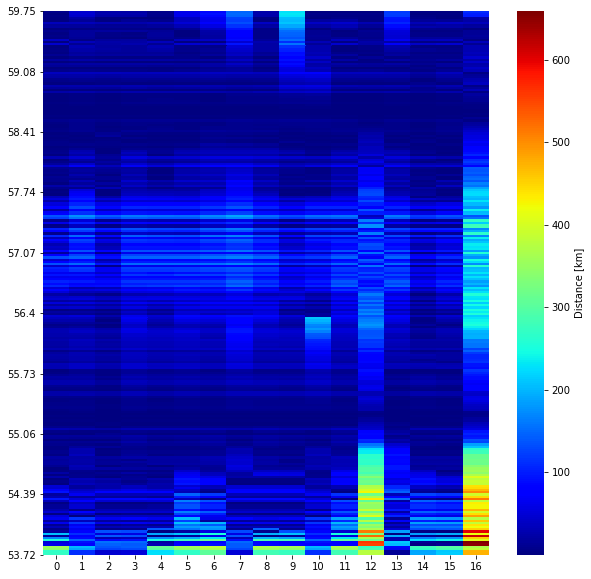

In [104]:
plt.figure(figsize=(10,10))
d_km = np.flip(np.array(d_km))
# plt.imshow(d_km.transpose(), cmap='jet', interpolation='nearest')
# plt.colorbar(
ax = sns.heatmap(d_km.transpose(), cmap='jet', cbar_kws={'label': 'Distance [km]'})
ax.set_yticks(np.linspace(d_km.shape[1],0,10))
ytick_labels = np.round(np.linspace(coastlat[0],coastlat[-1],10),2)
ax.set_yticklabels(ytick_labels)

xtick_labels = years_sina
ax.set_xticklabels(xtick_labels)

plt.ylabel('Latitude')
plt.title('March')
